# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 9: Incredible Natural Abundance Double Quantum Transfer Experiment (INADEQUATE)

INADEQUATE can be used to supress solvent (H2O) in H1 spectroscopy. In this tutorial we consider three H1 spins. Two are coupled and we will see how this pulse sequence will eleminate the third spin by phase cycling.

Some Basics:

Multiple Quantum Coherence -> 2IxSx, 2IySx, 2IxSy, 2IySy

Double Quantum Coherence, DQx = 1/2 * (2IxSx - 2IySy)

Double Quantum Coherence, DQy = 1/2 * (2IySx + 2IxSy)

Zero Quantum Coherence, DQx = 1/2 * (2IxSx + 2IySy)

Zero Quantum Coherence, DQy = 1/2 * (2IySx - 2IxSy)

Reference book "NMR: The Toolkit, How Pulse Sequences Work" by P.J Hore, J.A. Jones and S. Wimperis

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *
from IPython.display import display, Math, Latex

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2,1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaH1,System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 9.4

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [10,50,100] # Offset frequency in Hz

"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-400.22802765 -400.22806765 -400.22811765]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


## Zeeman Halitonian in Rotating Frame

In [8]:
OmegaRF = [-System.gammaH1*B0,-System.gammaH1*B0,-System.gammaH1*B0]
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## J Coupling Hamiltonian

In [9]:
"""
Define J Coupling between each spins, Jlist[0][3] means J coupling between 1st spin and 4th spin.
"""

Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 10 # Spin 1 and 2 are coupled
Jlist[0][2] = 0  # spin 1 and 3 not coupled
Jlist[1][2] = 0  # spin 2 and 3 not coupled

Hj = System.Jcoupling_Weak(Jlist,Sz)

## Relaxation Constant

In [10]:
'''
Define longitudinal (R1) and transverse Relaxation (R2)
''';

R1 = 1.0
R2 = 2.0
System.Relaxation_Constants(R1,R2)

'''
Options for "Rprocess": "No Relaxation" or "Phenomenological" 
                         or "Random Field Fluxtuation" or "Dipolar"
''';
Rprocess = "No Relaxation"

## Pulse 90x on all H1

In [11]:
pulse_angle = 90.0
rho = System.Rotate_H(rho_in,pulse_angle,Sx[0]+Sx[1]+Sx[2]) 

## Detect H1

In [12]:
dt = 1.0e-4
fs = 1.0/dt
AQ = 5.0
Npoints = int(AQ/dt)
print("Number of points in the simulation", Npoints)

"""
option for solver, "method": "Unitary Propagator" or "ODE Solver"
"""
method = "Unitary Propagator"

start_time = time.time()
t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr + Hj,dt,Npoints,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Exp_H1 = (Sx[0]+Sx[1]+Sx[2]) + 1j * (Sy[0]+Sy[1]+Sy[2])
t, Mt_H1_normal = System.Expectation_H(rho_t,Exp_H1,dt,Npoints)

Number of points in the simulation 50000
Total time = 0.269942045211792 seconds 


## INADEQUATE

In [13]:
delta = 1/(4*Jlist[0][1])

# Phase of pulse for Phase Cycling
Ph1 = [0,90]
Ph2 = [90,180]
Ph3 = [0,90]
Sig_add = [1,-1]



def INADEQUATE(rho_in,rhoeq,delta,dt,AQ,Ph1,Ph2,Ph3,Sig_add):
    Npoints = int(AQ/dt)
    signal = np.zeros((Npoints),dtype=np.cdouble)
    method = "Unitary Propagator"
    l = 0
    for i,j,k in zip(Ph1,Ph2,Ph3):
        
        # 90 pulse on all spins
        rho = System.Rotate_H(rho_in,90,System.Pulse_Phase(Sx,Sy,i))
        
        # First delta 
        Dpoints = int(delta/dt)
        t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr + Hj,dt,Dpoints,method,Rprocess)
        
        # 180 pulse on all spins
        rho = System.Rotate_H(rho_t[-1],180,System.Pulse_Phase(Sx,Sy,j))
        
        # Second delta 
        t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr + Hj,dt,Dpoints,method,Rprocess)
        
        # 90 pulse on all spins
        rho = System.Rotate_H(rho_t[-1],90,System.Pulse_Phase(Sx,Sy,k))
        
        # 90 pulse on all spins
        rho = System.Rotate_H(rho,90,Sx[0]+Sx[1]+Sx[2])
        
        # Detection
        t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr + Hj,dt,Npoints,method,Rprocess)
        Exp_H1 = (Sx[0]+Sx[1]+Sx[2]) + 1j * (Sy[0]+Sy[1]+Sy[2])
        t, Mt_H1_inadequate = System.Expectation_H(rho_t,Exp_H1,dt,Npoints)
        
        signal = signal + Sig_add[l] * Mt_H1_inadequate
        l = l + 1    
        
    return t, signal 

start_time = time.time()
t, Mt_H_inadequate = INADEQUATE(rho_in,rhoeq,delta,dt,AQ,Ph1,Ph2,Ph3,Sig_add)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Total time = 1.1808011531829834 seconds 


## Windowing

In [14]:
Mt_H1_normal = System.WindowFunction(t,Mt_H1_normal,5.0)
Mt_H_inadequate = System.WindowFunction(t,Mt_H_inadequate,5.0)

## Fourier Transform

In [15]:
fs = 1.0/dt
freq, spectrum_normal = System.FourierTransform(Mt_H1_normal,fs,5)
freq, spectrum_inadequate = System.FourierTransform(Mt_H_inadequate,fs,5)

## Plotting

<IPython.core.display.Javascript object>


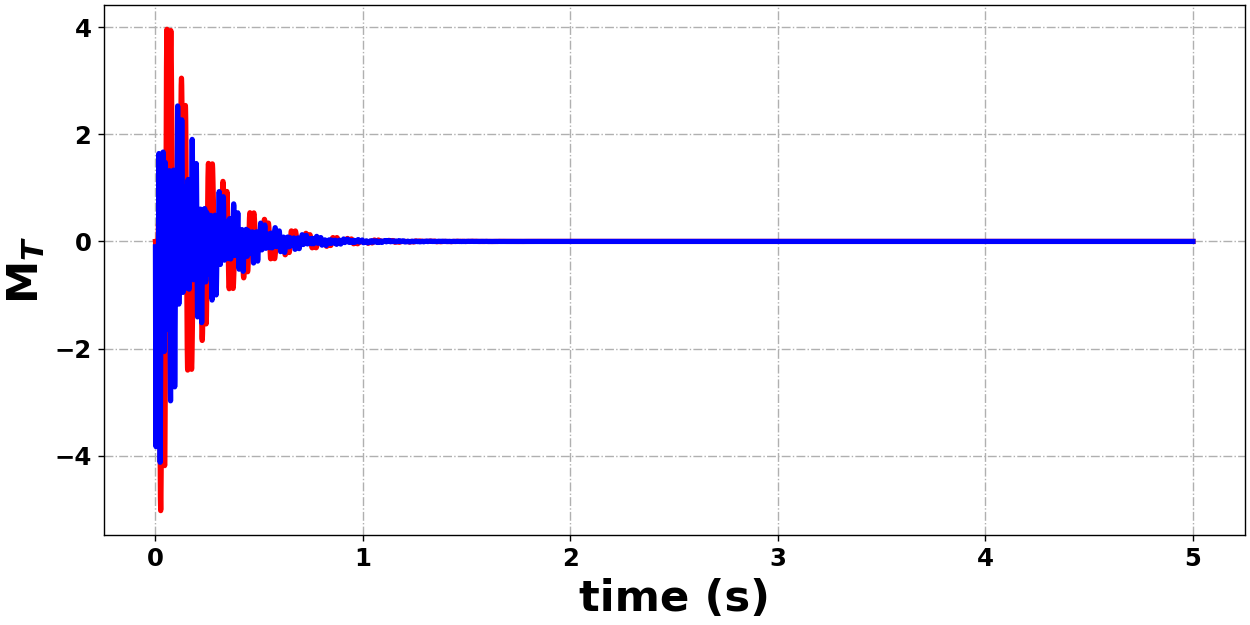

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [16]:
'''
Red: INADEQUATE
Blue: Normal (90deg pulse and detect H1)
''';
System.PlottingMulti(3,[t,t],[Mt_H_inadequate,Mt_H1_normal],"time (s)",R"M$_{T}$",["red","blue"])

<IPython.core.display.Javascript object>


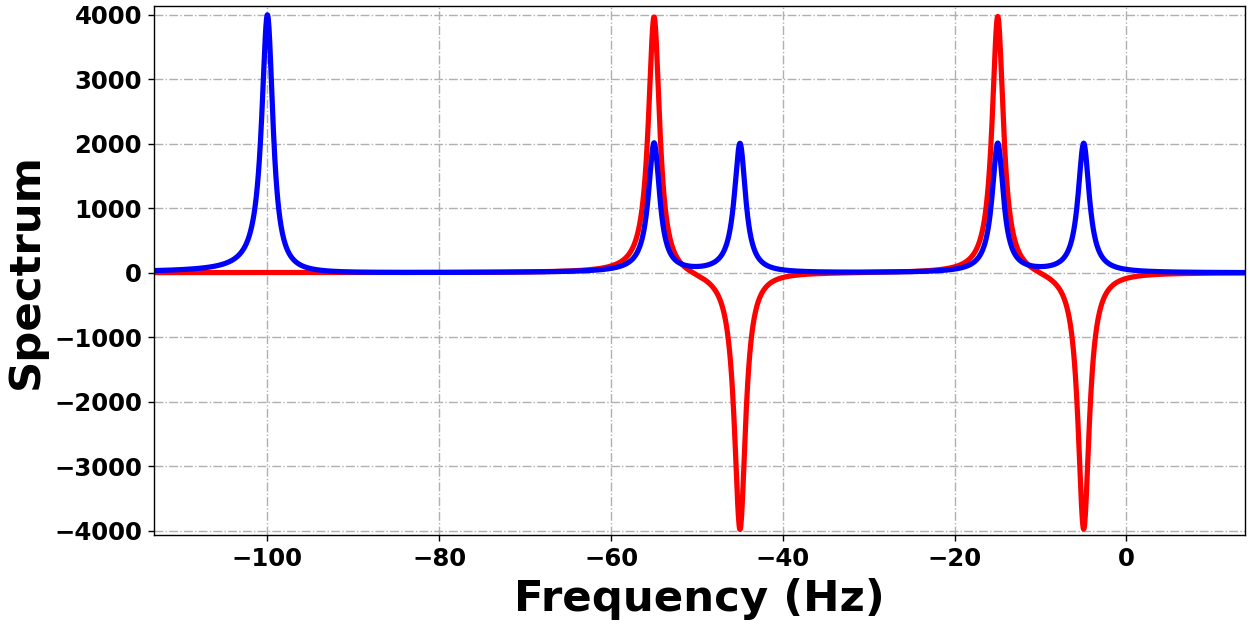

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [17]:
'''
Red: INADEQUATE
Blue: Normal (90deg pulse and detect H1)
''';
spectrum_inadequate_PH0 = System.PhaseAdjust_PH0(spectrum_inadequate,0.0)
Spectrum_normal_PH0 = System.PhaseAdjust_PH0(spectrum_normal,45.0)
System.PlottingMulti(4,[freq,freq],[spectrum_inadequate_PH0,Spectrum_normal_PH0],"Frequency (Hz)","Spectrum",["red","blue"])

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com